In [31]:
# Import packages
import os
import numpy as np
import pandas as pd
from scipy.stats import tvar, skew, kurtosis, zscore
from scipy.integrate import simps
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import KNNImputer
from sklearn import svm

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

from utils.dataloaders import OneSignal
from utils import random_state
# import random

import matplotlib.pyplot as plt
import seaborn as sns

random_state(36)

In [32]:
# def fit_preprocess(train_full_features, features_selected):
#   feature_list = train_full_features.columns

#   # ----------1. OUTLIER REMOVAL----------------
#   # apply zscore
#   scaler_outliers = StandardScaler().fit(train_full_features)
#   zscore_features = scaler_outliers.transform(train_full_features)

#   # select all those values with zscore > -+ 3  as outliers
#   abs_zscores = np.abs(zscore_features)
#   outliers_detected = abs_zscores > 3
#   print('Outliers detected (train): ' + str(np.sum(np.sum(outliers_detected))))

#   # set outliers as missing values
#   train_full_features[outliers_detected] = np.nan
#   train_full_features =  pd.DataFrame(data=train_full_features, columns=feature_list)
#   print('Missing values after outlier removal (train): ' + str(train_full_features.isnull().sum().sum()))

#   # ----------2. MISSING VALUES IMPUTATION..........
#   # remove patients in training set with high percentage of missing data (TRAINING)
#   n_patiens_before = np.shape(train_full_features)[0]
#   train_full_features = train_full_features.dropna(thresh=np.shape(train_full_features)[1]/3)
#   n_patiens_after = np.shape(train_full_features)[0]
#   print('Number of patients dropped: ' + str(n_patiens_before-n_patiens_after))

#   imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
#   # fit on the dataset
#   imputer.fit(train_full_features)

#   train_full_features = imputer.transform(train_full_features)
#   train_full_features =  pd.DataFrame(data=train_full_features, columns=feature_list)

#   # ---------------3. FEATURE SCALING ---------------
#   transformer = StandardScaler().fit(train_full_features)
#   train_full_features = transformer.transform(train_full_features)
#   train_full_features = pd.DataFrame(data=train_full_features, columns=feature_list)

#   #----------------4. FEATURE SELECTION-----------------
#   train_full_features = train_full_features[features_selected]


#   feature_preprocessing = {'outlier_removal_scaler': scaler_outliers,
#                           'KNN_imputer': imputer,
#                           'scaler': transformer,
#                           'features_selected': features_selected}
#   return  feature_preprocessing

# def feature_preprocess(test_features, feature_preprocessing):
#   # test set preprocessing
#   feature_list = test_features.columns

#   # outlier removal
#   zscore_features = feature_preprocessing['outlier_removal_scaler'].transform(test_features)
#   outliers_detected = np.abs(zscore_features) > 3
#   print('Outliers detected (validation): ' + str(np.sum(np.sum(outliers_detected))))

#   test_features[outliers_detected] = np.nan
#   test_features =  pd.DataFrame(data=test_features, columns=feature_list)
#   print('Missing values after outlier removal (validation): ' + str(test_features.isnull().sum().sum()))

#   # missing data imputation
#   test_features = feature_preprocessing['KNN_imputer'].transform(test_features)
#   test_features =  pd.DataFrame(data=test_features, columns=feature_list)

#   # feature preprocessing
#   test_features = feature_preprocessing['scaler'].transform(test_features)
#   test_features = pd.DataFrame(data=test_features, columns=feature_list)

#   # feature selection
#   test_features = test_features[features_selected]

#   return  test_features

# # Training set creation and preprocessing
# train_full_labels = train_full.label
# train_full_features = train_full.drop(columns='label')
# features_selected = train_features.columns

# # Training set
# feature_preprocessing = fit_preprocess(train_full_features, features_selected)
# # Test set
# test_features = feature_preprocess(test_features, feature_preprocessing)

def plot_correlationMatrix(correlation_matrix, features):
    f = plt.figure(figsize=(10, 8))
    plt.matshow(correlation_matrix, fignum=f.number)
    plt.xticks(range(len(features)), features, fontsize=10, rotation=90)
    plt.yticks(range(len(features)), features, fontsize=10)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    #plt.title('Correlation Matrix', fontsize=16)
    # plt.tight_layout()
    return

def plot_outliersAnalysis(abs_zscores, feature_list):
  # # number of outliers per subject
  # bool_zscores = (abs_zscores > 3).sum(axis=1)
  # bool_zscores.hist()
  # plt.title("Number of outliers per subject")
  # plt.show()

  # number of outliers per feature
  bool_zscores = (abs_zscores > 3).sum(axis=0)
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])

  ax.bar(feature_list,bool_zscores)
  plt.title("Number of outliers per feature")
  plt.xticks(np.arange(len(feature_list)), feature_list, rotation=90)
  plt.show()
  return

# def plot_PCAanalysis(train_features_pca, pc_plot):
#   principalComponents_Df = pd.DataFrame(data = train_features_pca[:,pc_plot],
#                                       columns = ['principal component 1', 'principal component 2'])
#   plt.figure()
#   plt.figure(figsize=(10,10))
#   plt.xticks(fontsize=12)
#   plt.yticks(fontsize=14)
#   plt.xlabel('Principal Component - 1',fontsize=20)
#   plt.ylabel('Principal Component - 2',fontsize=20)
#   plt.title("Principal Component Analysis",fontsize=20)
#   targets = [0, 1]
#   colors = ['r', 'g']
#   for target, color in zip(targets,colors):
#     indicesToKeep = np.array(train_labels) == target
#     plt.scatter(principalComponents_Df.loc[indicesToKeep, 'principal component 1']
#                 , principalComponents_Df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

#   plt.legend(targets,prop={'size': 15})
#   return

def plot_recurrentFE(min_features_to_select, rfecv):
  plt.figure()
  plt.xlabel("Number of features selected")
  plt.ylabel("Cross validation score (accuracy)")
  n_features = len(rfecv.cv_results_['mean_test_score'])
  plt.plot(range(min_features_to_select, min_features_to_select + n_features), rfecv.cv_results_['mean_test_score'])
  plt.show()

def plot_confusionMatrix(test_labels, test_predicted, clf):
  cm = confusion_matrix(test_labels, test_predicted, labels=clf.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=clf.classes_)
  disp.plot()
  plt.show()
  return

def testModel(train_features, train_labels, test_features, test_labels):
  clf = svm.SVC(C=1.0,
              kernel='rbf', # linear ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
              degree=6,
              gamma='scale',
              coef0=0.0,
              shrinking=True,
              probability=False,
              tol=0.001,
              cache_size=200,
              class_weight=None,
              verbose=False,
              max_iter=- 1,
              decision_function_shape='ovr',
              break_ties=False)


  clf.fit(train_features, train_labels)

  # d. Predit test labels
  test_predicted = clf.predict(test_features)

  # e. plot confusion matrix
  plot_confusionMatrix(test_labels, test_predicted, clf)

  # f. display classification results
  print(classification_report(test_labels, test_predicted, target_names=clf.classes_))

  return clf, test_predicted

def testModel_2(train_features, train_labels, test_features, test_labels, clf):
  clf.fit(train_features, train_labels)

  # d. Predit test labels
  test_predicted = clf.predict(test_features)

  # e. plot confusion matrix
  plot_confusionMatrix(test_labels, test_predicted, clf)

  # f. display classification results
  print(classification_report(test_labels, test_predicted, target_names=clf.classes_))

In [33]:
#---------------------------------------------------
#               Get features dataframe
#---------------------------------------------------

def merge_csv_files(folder_path):
    # Get a list of all CSV files in the specified folder
    csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

    # Initialize an empty list to store individual DataFrames
    dfs = []

    # Loop through each CSV file and append its DataFrame to the list
    for csv_file in csv_files:
        file_path = os.path.join(folder_path, csv_file)
        df = pd.read_csv(file_path)
        dfs.append(df)

    # Concatenate all DataFrames in the list into a single DataFrame
    merged_df = pd.concat(dfs, ignore_index=True)

    return merged_df

# Load the csv file containing the features
current_directory = os.path.dirname(os.path.abspath('__file__'))
folder_name = 'dataset/ML_features/'
folder_path = os.path.join(current_directory, folder_name)

df = merge_csv_files(folder_path)

In [34]:
#---------------------------------------------------
#           Construct train/val/test split
#---------------------------------------------------

# Construct patient numbers
patient_numbers = [i for i in range(1, 122) if i not in [107, 120]+list(range(63, 79))]
# Set random state: reproducibility
random_state(36)

# Split the data into training (70%), validation (15%) and test (15%) sets
train_numbers, non_train_numbers = train_test_split(patient_numbers, test_size=0.3, random_state=36)
val_numbers, test_numbers = train_test_split(non_train_numbers, test_size=0.5, random_state=36)

# Print the lengths of the sets
print(f"Training set size:\t{len(train_numbers)}")
print(f"Validation set size:\t{len(val_numbers)}")
print(f"Test set size:\t\t{len(test_numbers)}")

# Select rows where the 'name' column is in the predetermined list
train_data = df[df['name'].isin(train_numbers)]
val_data = df[df['name'].isin(val_numbers)]
test_data = df[df['name'].isin(test_numbers)]

Training set size:	72
Validation set size:	15
Test set size:		16


Missing values before outlier removal: 0
Outliers detected (train): 37618
Missing values after outlier removal (train): 37618
Outliers detected (validation): 11026
Missing values after outlier removal (validation): 11026


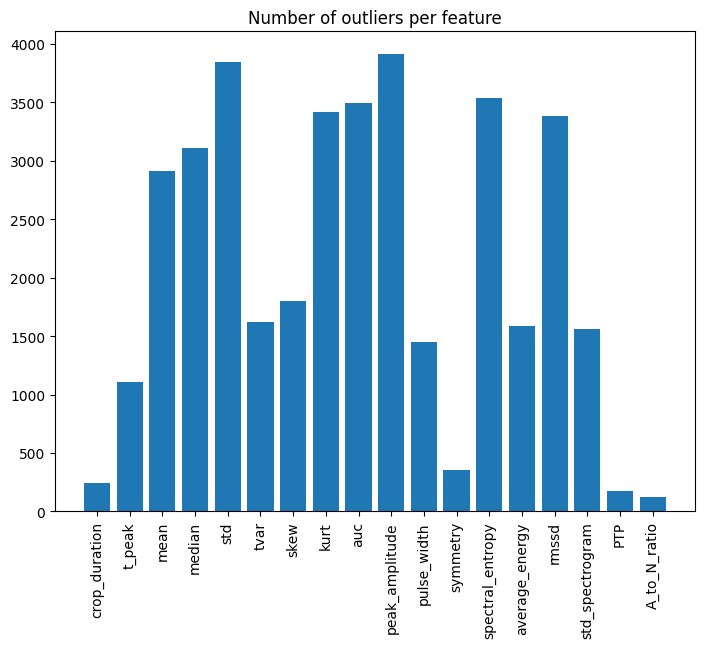

In [35]:
#---------------------------------------------------
#               Outlier removal
#---------------------------------------------------

# Read in as copy
train_features = train_data.copy()
validation_features = val_data.copy()
test_features = test_data.copy()

# Drop "useless" features
train_features = train_features.drop(columns=['peaks', 'name'])
validation_features = validation_features.drop(columns=['peaks', 'name'])
test_features = test_features.drop(columns=['peaks', 'name'])

# Select labels
train_labels = train_features['labels']
validation_labels = validation_features['labels']
# test_labels = test_features['labels']

# Identify numeric columns
numeric_columns = train_features.select_dtypes(include=np.number).columns

# Separate non-numeric columns (e.g., 'labels')
non_numeric_columns = ['labels']

# Store non-numeric data
train_non_numeric = train_features[non_numeric_columns]
validation_non_numeric = validation_features[non_numeric_columns]
# test_non_numeric = test_features[non_numeric_columns]

# Drop non-numeric columns for scaling
train_features = train_features.drop(columns=non_numeric_columns)
validation_features = validation_features.drop(columns=non_numeric_columns)
# test_features = test_features.drop(columns=non_numeric_columns)

feature_list = train_features.columns
print('Missing values before outlier removal: ' + str(train_features.isnull().sum().sum()))

# apply zscore only to numeric columns
scaler = StandardScaler().fit(train_features[numeric_columns])
zscore_features = scaler.transform(train_features[numeric_columns])

# select all those values with zscore > -+ 3 as outliers
abs_zscores_train = np.abs(zscore_features)

outliers_detected = abs_zscores_train > 3
print('Outliers detected (train): ' + str(np.sum(np.sum(outliers_detected))))

# set outliers as missing values
train_features[outliers_detected] = np.nan

# Concatenate scaled numeric features with non-numeric columns
train_features = pd.concat([train_non_numeric, train_features], axis=1)

print('Missing values after outlier removal (train): ' + str(train_features.isnull().sum().sum()))

# Apply to validation set
zscore_features = scaler.transform(validation_features[numeric_columns])
abs_zscores = np.abs(zscore_features)
outliers_detected = abs_zscores > 3
print('Outliers detected (validation): ' + str(np.sum(np.sum(outliers_detected))))

validation_features[outliers_detected] = np.nan

validation_features = pd.concat([validation_non_numeric, validation_features], axis=1)

print('Missing values after outlier removal (validation): ' + str(validation_features.isnull().sum().sum()))

plot_outliersAnalysis(abs_zscores_train, feature_list)


In [36]:
drop_nan = True

if drop_nan == True:
    train_features = train_features.dropna()
    validation_features = validation_features.dropna()
    # test_features = test_features.dropna()

In [37]:
train_features

,labels,crop_duration,t_peak,mean,median,std,tvar,skew,kurt,auc,peak_amplitude,pulse_width,symmetry,spectral_entropy,average_energy,rmssd,std_spectrogram,PTP,A_to_N_ratio
2603,S,1.187500,0.531250,-0.137542,-0.174041,0.610203,0.374813,0.327304,0.122749,0.573471,2.644502,0.179688,-4.521716,1.419786,0.004996,0.040979,0.026642,0.765439,0.000000
2604,N,0.835938,0.257812,0.191867,-0.028647,1.073234,1.162698,0.404985,-0.767363,0.676881,3.688874,0.195312,-0.441466,1.159771,0.014821,0.090450,0.071151,0.937500,1.000000
2605,N,0.828125,0.648438,-0.134108,-0.108065,1.106474,1.235944,-0.168062,-1.320787,0.800139,3.399380,0.140625,0.090509,1.002858,0.020052,0.124543,0.112323,0.812500,1.000000
2606,N,0.710938,0.195312,0.026860,0.115230,1.909596,3.687074,-0.486495,-0.337794,0.996920,7.030406,0.171875,-0.938495,1.080086,0.045897,0.145430,0.233011,0.796875,0.500000
2607,N,0.664062,0.375000,0.274432,0.500693,2.383523,5.748813,-0.367361,-1.096476,1.356800,7.457452,0.234375,-1.494914,0.924359,0.074953,0.156147,0.422145,0.804688,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244128,N,0.728000,0.256000,0.305786,0.607647,1.094490,1.204527,-0.734365,-0.270232,0.708380,4.014716,0.188000,1.178893,1.194078,0.006386,0.049120,0.035931,0.696000,0.000000
244129,N,0.720000,0.208000,-0.105226,-0.452086,1.028114,1.062923,0.216009,-0.807216,0.625204,3.708280,0.168000,-1.330612,1.008371,0.007419,0.042227,0.057636,0.700000,0.000000
244130,N,0.768000,0.244000,-0.042105,0.040649,0.939306,0.886916,-0.259986,-0.546747,0.544550,3.530775,0.164000,-1.526166,1.257259,0.004936,0.044077,0.028181,0.748000,0.000000
244131,N,0.600000,0.240000,0.347119,-0.043418,0.939167,0.887954,0.252589,-0.978847,0.455624,3.223087,0.176000,0.235690,1.044008,0.006288,0.047865,0.038924,0.768000,0.000000


In [38]:
# # Check for NaN values in the entire DataFrame
# nan_in_dataframe = train_features.isnull().sum().sum()
# print(f'Total NaN values in the DataFrame: {nan_in_dataframe}')

# # Check for NaN values in each column
# nan_in_columns = train_features.isnull().sum()
# print('NaN values in each column:')
# print(nan_in_columns)

In [39]:
#---------------------------------------------------
#               Subsampling
#---------------------------------------------------

# Parameters
stratify = True
random_seed = 36

# Construct df
train_df = train_features.copy()
display(train_df)
val_df = validation_features.copy()
test_df = test_features.copy()

print('Distribution before subsampling:')
data = {}
for split_name, df in zip(["train", "val", "test"], [train_df, val_df, test_df]):

    # Subsampling
    df_N = df[df['labels'] == 'N']  #0
    df_V = df[df['labels'] == 'V']  #1
    df_S = df[df['labels'] == 'S']  #2
            
    n_smallest_class = min(len(df_N), len(df_V), len(df_S))
    print(len(df_N), len(df_V), len(df_S))

    if split_name in ["train", "val"]:
        if stratify:
            # Use the sample method to get a random subset
            df_N = df_N.sample(n=2*n_smallest_class, random_state=36)
            df_V = df_V.sample(n=n_smallest_class, random_state=36)
            df_S = df_S.sample(n=n_smallest_class, random_state=36)

    # Now put them all back together       
    df = pd.concat([df_N, df_V, df_S], axis=0, ignore_index=True)
    
    # Shuffle the dataframe
    df = df.sample(frac=1).reset_index(drop=True)

    # Assign the modified DataFrame back to the original variable
    data[split_name] = df

train_features = data['train']
validation_features = data['val']
test_features = data['test']

print(('\nDistribution after subsampling:'))
print(train_features['labels'].value_counts())
print(validation_features['labels'].value_counts())
print(test_features['labels'].value_counts())

,labels,crop_duration,t_peak,mean,median,std,tvar,skew,kurt,auc,peak_amplitude,pulse_width,symmetry,spectral_entropy,average_energy,rmssd,std_spectrogram,PTP,A_to_N_ratio
2603,S,1.187500,0.531250,-0.137542,-0.174041,0.610203,0.374813,0.327304,0.122749,0.573471,2.644502,0.179688,-4.521716,1.419786,0.004996,0.040979,0.026642,0.765439,0.000000
2604,N,0.835938,0.257812,0.191867,-0.028647,1.073234,1.162698,0.404985,-0.767363,0.676881,3.688874,0.195312,-0.441466,1.159771,0.014821,0.090450,0.071151,0.937500,1.000000
2605,N,0.828125,0.648438,-0.134108,-0.108065,1.106474,1.235944,-0.168062,-1.320787,0.800139,3.399380,0.140625,0.090509,1.002858,0.020052,0.124543,0.112323,0.812500,1.000000
2606,N,0.710938,0.195312,0.026860,0.115230,1.909596,3.687074,-0.486495,-0.337794,0.996920,7.030406,0.171875,-0.938495,1.080086,0.045897,0.145430,0.233011,0.796875,0.500000
2607,N,0.664062,0.375000,0.274432,0.500693,2.383523,5.748813,-0.367361,-1.096476,1.356800,7.457452,0.234375,-1.494914,0.924359,0.074953,0.156147,0.422145,0.804688,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244128,N,0.728000,0.256000,0.305786,0.607647,1.094490,1.204527,-0.734365,-0.270232,0.708380,4.014716,0.188000,1.178893,1.194078,0.006386,0.049120,0.035931,0.696000,0.000000
244129,N,0.720000,0.208000,-0.105226,-0.452086,1.028114,1.062923,0.216009,-0.807216,0.625204,3.708280,0.168000,-1.330612,1.008371,0.007419,0.042227,0.057636,0.700000,0.000000
244130,N,0.768000,0.244000,-0.042105,0.040649,0.939306,0.886916,-0.259986,-0.546747,0.544550,3.530775,0.164000,-1.526166,1.257259,0.004936,0.044077,0.028181,0.748000,0.000000
244131,N,0.600000,0.240000,0.347119,-0.043418,0.939167,0.887954,0.252589,-0.978847,0.455624,3.223087,0.176000,0.235690,1.044008,0.006288,0.047865,0.038924,0.768000,0.000000


Distribution before subsampling:
148044 4041 5397
26276 711 543
35199 2355 1146

Distribution after subsampling:
labels
N    8082
S    4041
V    4041
Name: count, dtype: int64
labels
N    1086
V     543
S     543
Name: count, dtype: int64
labels
N    35199
V     2355
S     1146
Name: count, dtype: int64


In [40]:
train_features

,labels,crop_duration,t_peak,mean,median,std,tvar,skew,kurt,auc,peak_amplitude,pulse_width,symmetry,spectral_entropy,average_energy,rmssd,std_spectrogram,PTP,A_to_N_ratio
0,S,0.617188,0.218750,-0.233686,-0.254209,0.530108,0.284617,-0.205474,-1.032649,0.291266,1.766544,0.148438,-4.898490,0.896018,0.003871,0.038446,0.022246,0.578125,0.769231
1,N,0.588000,0.204000,0.007590,-0.088380,0.682555,0.469072,0.165874,-1.185815,0.339778,2.230327,0.156000,-0.944000,1.010701,0.003162,0.032839,0.022494,0.600000,0.000000
2,V,0.906250,0.023438,0.351097,0.400569,1.781488,3.201296,-0.472222,-0.824209,1.400694,6.570092,0.382812,-0.623611,1.002851,0.032356,0.128094,0.177358,0.453125,0.450000
3,N,0.578125,0.218750,-0.147505,-0.235952,0.825997,0.691618,0.161763,-1.331204,0.418349,2.510674,0.148438,-2.822430,0.995402,0.008929,0.076556,0.044829,0.585938,0.031250
4,V,0.617188,0.156250,-0.446143,-0.586213,0.686750,0.477672,0.037079,-1.354452,0.417296,2.220696,0.132812,-5.736833,0.661203,0.006724,0.045927,0.038332,0.390625,0.156250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16159,N,0.840000,0.240000,-0.196045,-0.344229,0.866858,0.755038,0.492175,-0.634454,0.628282,3.070091,0.164000,-2.671280,1.212170,0.005037,0.038863,0.033537,0.872000,0.000000
16160,N,0.916000,0.276000,0.524517,0.949662,1.163393,1.359419,-0.568205,-0.805830,1.040147,4.087105,0.416000,0.536665,1.022297,0.007140,0.042697,0.050087,0.868000,0.000000
16161,V,0.921875,0.453125,-0.071413,-2.788462,6.670381,44.874274,1.218788,0.041477,5.016650,22.176320,0.164062,-1.752340,1.258751,0.752586,0.599220,3.730308,0.429688,0.142857
16162,N,0.882812,0.281250,0.018281,-0.077585,0.954636,0.919467,0.200688,-1.170632,0.711251,3.085900,0.218750,-0.901237,1.016617,0.011892,0.064874,0.070394,0.906250,0.000000


In [41]:
#---------------------------------------------------
#               Data standardization
#---------------------------------------------------

# Standarize data with z-score transformation
# Select labels
train_labels = train_features['labels']
validation_labels = validation_features['labels']
test_labels = test_features['labels']

# Drop "useless" features
train_features_zscore = train_features.copy().drop(columns=['labels'])
validation_features_zscore = validation_features.copy().drop(columns=['labels'])
test_features_zscore = test_features.copy().drop(columns=['labels'])

feature_list = train_features_zscore.columns

transformer = StandardScaler().fit(train_features_zscore)
train_features_zscore = transformer.transform(train_features_zscore)
train_features_zscore = pd.DataFrame(data=train_features_zscore, columns=feature_list)

# adapt validation set
validation_features_zscore = transformer.transform(validation_features_zscore)
validation_features_zscore = pd.DataFrame(data=validation_features_zscore, columns=feature_list)
# adapt test set
test_features_zscore = transformer.transform(test_features_zscore)
test_features_zscore = pd.DataFrame(data=test_features_zscore, columns=feature_list)

display(train_features_zscore)

,crop_duration,t_peak,mean,median,std,tvar,skew,kurt,auc,peak_amplitude,pulse_width,symmetry,spectral_entropy,average_energy,rmssd,std_spectrogram,PTP,A_to_N_ratio
0,-0.638496,-0.424629,-0.191860,-0.209533,-0.520554,-0.257981,-0.231425,-0.211252,-0.527267,-0.522522,-0.597984,-0.375126,-0.380677,-0.263930,-0.519690,-0.252781,-0.244270,2.454163
1,-0.779758,-0.534200,0.089726,-0.064526,-0.456401,-0.252424,0.693671,-0.574968,-0.498311,-0.462593,-0.516422,0.027623,0.254064,-0.265962,-0.557563,-0.252668,-0.134414,-0.752232
2,0.760516,-1.875518,0.490623,0.363030,0.006050,-0.170113,-0.895945,0.283720,0.134913,0.098179,1.929778,0.060253,0.210617,-0.182249,0.085766,-0.182186,-0.872020,1.123509
3,-0.827551,-0.424629,-0.091281,-0.193569,-0.396038,-0.245719,0.683429,-0.920215,-0.451415,-0.426367,-0.597984,-0.163688,0.169389,-0.249425,-0.262308,-0.242503,-0.205035,-0.621972
4,-0.638496,-0.888913,-0.439812,-0.499850,-0.454636,-0.252165,0.372818,-0.975422,-0.452044,-0.463837,-0.766502,-0.460508,-1.680316,-0.255750,-0.469165,-0.245460,-1.185896,-0.100933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16159,0.439877,-0.266772,-0.147930,-0.288250,-0.378843,-0.243809,1.506546,0.734321,-0.326114,-0.354081,-0.430141,-0.148294,1.369138,-0.260586,-0.516877,-0.247642,1.231571,-0.752232
16160,0.807704,0.000656,0.693017,0.843178,-0.254056,-0.225601,-1.135055,0.327364,-0.080285,-0.222665,2.287709,0.178422,0.318244,-0.254557,-0.490983,-0.240109,1.211483,-0.752232
16161,0.836138,1.316438,-0.002475,-2.425581,2.063385,1.085323,3.316672,2.339419,2.293154,2.114770,-0.429467,-0.054704,1.626950,1.883023,3.267601,1.434838,-0.989724,-0.156758
16162,0.647082,0.039656,0.102204,-0.055086,-0.341905,-0.238855,0.780399,-0.538913,-0.276592,-0.352038,0.160345,0.031978,0.286807,-0.240928,-0.341208,-0.230868,1.403575,-0.752232


In [42]:
validation_features_zscore

,crop_duration,t_peak,mean,median,std,tvar,skew,kurt,auc,peak_amplitude,pulse_width,symmetry,spectral_entropy,average_energy,rmssd,std_spectrogram,PTP,A_to_N_ratio
0,-0.470009,-0.326200,2.447156,-0.728849,5.035136,5.449472,0.996997,-0.985927,3.962681,4.504378,-0.128157,0.057740,-0.380353,4.065105,2.749144,5.417387,1.492716,-0.752232
1,1.063005,0.620011,0.718237,0.666351,0.217981,-0.107967,-0.919300,0.280967,0.438893,0.231478,1.761260,0.082441,-0.423337,-0.083197,-0.071810,-0.049360,1.168169,-0.752232
2,-0.260385,-2.049624,0.311169,0.756946,0.250853,-0.096396,-1.310175,-0.010500,0.149335,0.196639,1.171449,0.041907,-2.155247,-0.086866,-0.079658,-0.086277,-1.578240,0.140978
3,1.117453,-0.088487,-0.004311,-0.013940,-0.304318,-0.233588,0.906991,-0.012997,-0.195473,-0.277559,0.001264,-0.005564,0.387104,-0.253580,-0.541446,-0.233287,1.392276,-0.752232
4,-1.621585,-0.598735,0.183821,0.108820,-0.566785,-0.261132,-0.503876,-0.339303,-0.611337,-0.574746,-0.513725,0.118559,-0.123625,-0.268464,-0.451222,-0.258509,-1.028958,0.209687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2167,-1.092229,-0.192486,-0.044023,-0.096907,-0.519011,-0.257842,0.303403,-1.268854,-0.553473,-0.546987,-0.513725,0.374430,-0.046057,-0.264155,-0.439831,-0.254701,-0.401207,-0.752232
2168,-0.600685,-0.714807,-0.171611,-0.036994,-0.455914,-0.252294,-0.320238,-0.621365,-0.480052,-0.464592,-0.429467,-0.092826,-1.450799,-0.256504,-0.500997,-0.245222,-1.028958,0.289847
2169,1.214249,-0.018380,0.081222,-0.048708,-0.317872,-0.235474,1.413597,0.708000,-0.241234,-0.293291,-0.092432,0.022041,1.471694,-0.236707,-0.279479,-0.230189,2.031326,-0.520659
2170,0.420216,0.561976,0.109220,0.077162,-0.299454,-0.232675,-0.069726,-1.006104,-0.244071,-0.345572,0.834414,0.047561,-0.060443,-0.236140,-0.336813,-0.225824,0.971997,-0.752232


In [43]:
# "EXERCISE III: Feature selection"
# from sklearn.feature_selection import VarianceThreshold
# from itertools import compress

# # 1. Eliminate low variance features
# train_features = train_features_zscore
# validation_features = validation_features_zscore


# vt = VarianceThreshold(threshold=(0.01)) ###############################################
# train_features_var = vt.fit_transform(train_features)
# mask = vt.get_support()

# train_features = train_features.loc[:, mask]

# # plot deleted features
# print('Deleted features: ' + str(list(compress(feature_list, ~mask))))

Deleted features: {'std_spectrogram', 'std', 'peak_amplitude', 'average_energy', 'tvar', 'rmssd'}


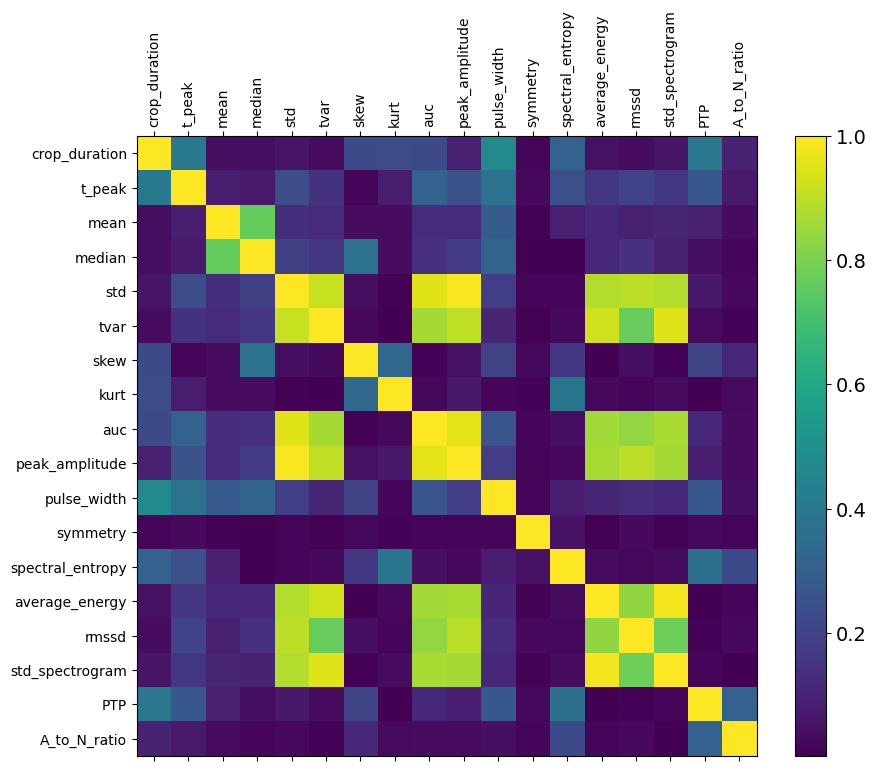

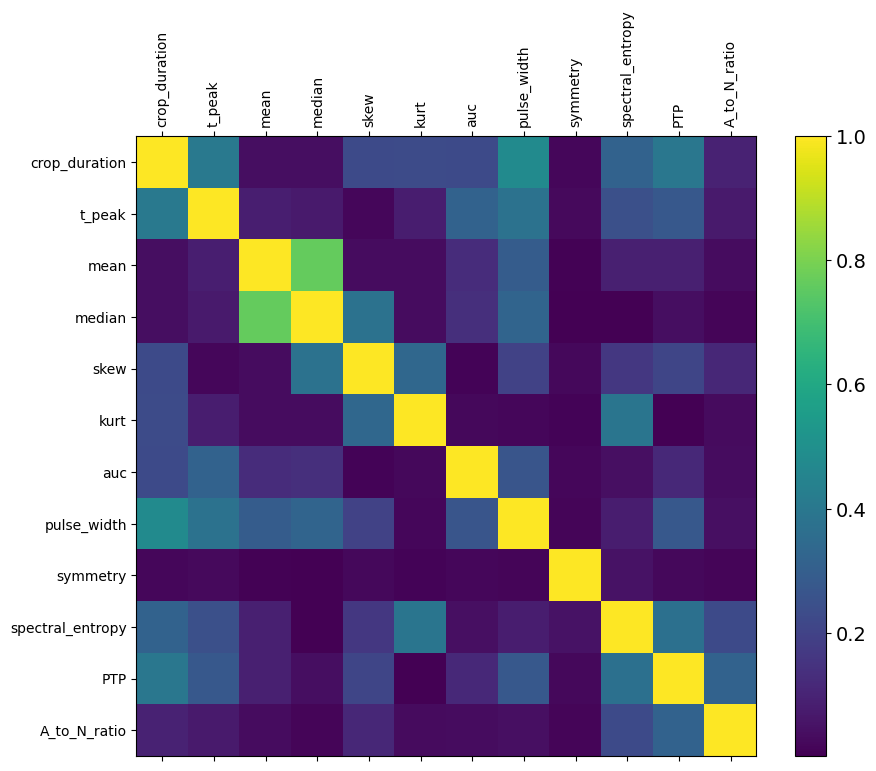

In [44]:
uncorr = True

if uncorr:
    # 2. Eliminate correlated features
    # a. visualize correlation matrix
    cor_matrix = train_features_zscore.corr().abs()
    plot_correlationMatrix(cor_matrix, feature_list)

    # b. drop correlated features
    correlated_features = set()
    correlation_matrix = train_features_zscore.corr()
    median_corr = (correlation_matrix.abs()).median(axis=0)

    for i in range(len(correlation_matrix .columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > 0.8: ##################################################
                if median_corr[i] < median_corr[j]:
                    colname = correlation_matrix.columns[i]
                else:
                    colname = correlation_matrix.columns[j]
                correlated_features.add(colname)

    # Drop correlated features
    train_features_zscore.drop(labels=correlated_features, axis=1, inplace=True)
    validation_features_zscore.drop(labels=correlated_features, axis=1, inplace=True)
    test_features_zscore.drop(labels=correlated_features, axis=1, inplace=True)

    # see how it drops correlated / drop the one that had a lower correlation w.r to the other feat
    print('Deleted features: ' + str(correlated_features))


    # c. plot correlation matrix with remaining features
    cor_matrix = train_features_zscore.corr().abs()
    feature_list = list(train_features_zscore.columns)
    f2 = plot_correlationMatrix(cor_matrix, feature_list)

    # adapt test set: pick only selected features
    validation_features = validation_features[feature_list]

In [45]:
def to_binary(labels):
  return labels.replace(['V', 'S'], 'A')


def testModel_2(train_features, train_labels, test_features, test_labels, clf, mode='binary'):
  if mode == 'binary':
    # Construct binary labels
    train_labels = to_binary(train_labels)
    test_labels = to_binary(test_labels)

  clf.fit(train_features, train_labels)

  # d. Predit test labels
  test_predicted = clf.predict(test_features)

  # e. plot confusion matrix
  plot_confusionMatrix(test_labels, test_predicted, clf)

  # f. display classification results
  print(classification_report(test_labels, test_predicted, target_names=clf.classes_))

  return clf, test_predicted

In [46]:
clf = svm.SVC(C=1.0,
            #   kernel='rbf', # linear ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
              kernel='linear', 
              degree=6,
              gamma='scale',
              coef0=0.0,
              shrinking=True,
              probability=False,
              tol=0.001,
              cache_size=200,
              class_weight=None,
              verbose=False,
              max_iter=- 1,
              decision_function_shape='ovr',
              break_ties=False)

In [47]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=80,
                        criterion='gini',
                        max_depth=None,
                        min_samples_split=2,
                        min_samples_leaf=1,
                        min_weight_fraction_leaf=0.0,
                        max_features='sqrt',
                        max_leaf_nodes=None,
                        min_impurity_decrease=0.0,
                        bootstrap=True,
                        oob_score=False,
                        n_jobs=None,
                        random_state=None,
                        verbose=0,
                        warm_start=False,
                        class_weight=None,
                        ccp_alpha=0.0,
                        max_samples=None)

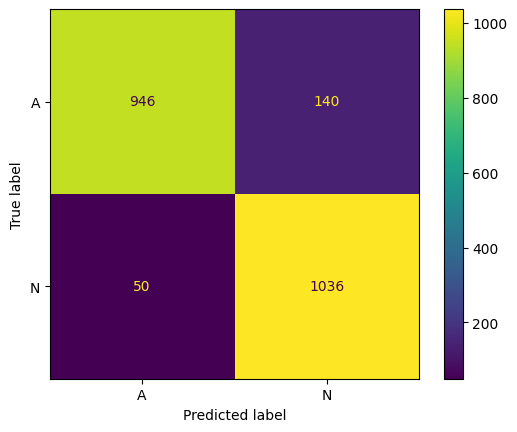

              precision    recall  f1-score   support

           A       0.95      0.87      0.91      1086
           N       0.88      0.95      0.92      1086

    accuracy                           0.91      2172
   macro avg       0.92      0.91      0.91      2172
weighted avg       0.92      0.91      0.91      2172



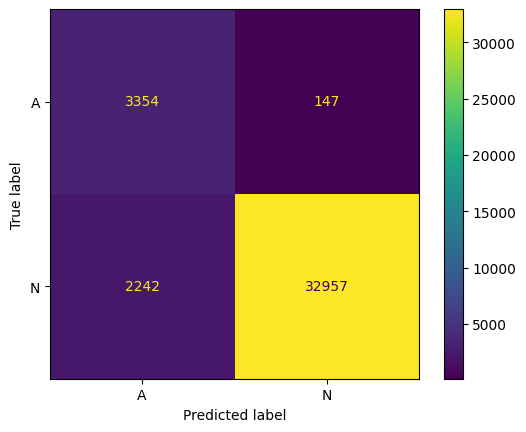

              precision    recall  f1-score   support

           A       0.60      0.96      0.74      3501
           N       1.00      0.94      0.97     35199

    accuracy                           0.94     38700
   macro avg       0.80      0.95      0.85     38700
weighted avg       0.96      0.94      0.94     38700



In [48]:
clf, val_prediction = testModel_2(train_features_zscore, train_labels, validation_features_zscore, validation_labels, clf)
clf, test_prediction = testModel_2(train_features_zscore, train_labels, test_features_zscore, test_labels, clf)

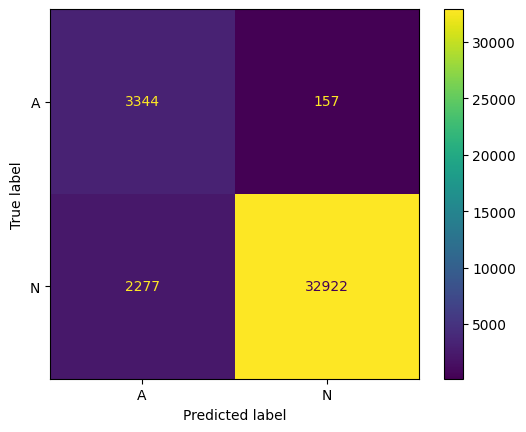

              precision    recall  f1-score   support

           A       0.59      0.96      0.73      3501
           N       1.00      0.94      0.96     35199

    accuracy                           0.94     38700
   macro avg       0.80      0.95      0.85     38700
weighted avg       0.96      0.94      0.94     38700



In [49]:
clf, test_prediction = testModel_2(train_features_zscore, train_labels, test_features_zscore, test_labels, clf)

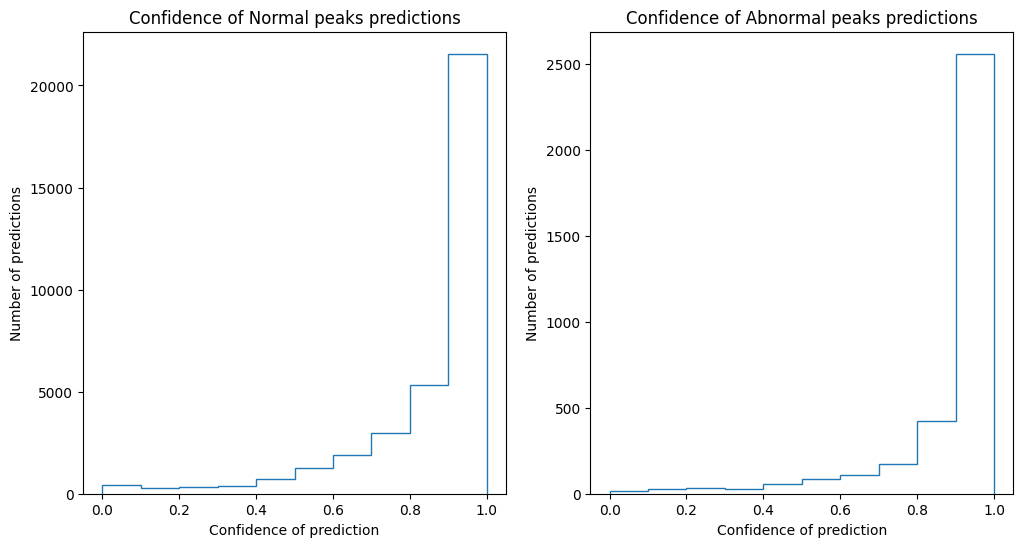

In [71]:
test_prediction_prob = clf.predict_proba(test_features_zscore)

# print(test_prediction_prob)

idx_N = np.where(test_labels == 'N')[0]
idx_A = np.where((test_labels == 'V')+(test_labels == 'S'))[0]

# Histogram predictions without error bars:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].set_title('Confidence of Normal peaks predictions')
axs[0].hist(test_prediction_prob[idx_N, 1], histtype='step')

axs[1].set_title('Confidence of Abnormal peaks predictions')
axs[1].hist(test_prediction_prob[idx_A, 0], histtype='step')

for ax in axs:
    ax.set_xlabel('Confidence of prediction')
    ax.set_ylabel('Number of predictions')
    # ax.legend()

plt.show()

In [72]:
test_prediction

array(['N', 'A', 'N', ..., 'N', 'N', 'N'], dtype=object)

In [84]:
# test_labels

pd.DataFrame(test_prediction) == 'A'

,0
0,False
1,True
2,False
3,False
4,True
...,...
38695,False
38696,False
38697,False
38698,False


In [93]:
check_df = test_data.copy()

check_df.labels[check_df.labels == 'V'] = 'A'
check_df.labels[check_df.labels == 'S'] = 'A'

classified_as_N = check_df[test_prediction == 'N']

classified_as_N[classified_as_N.labels == 'A']

,peaks,labels,crop_duration,t_peak,mean,median,std,tvar,skew,kurt,...,peak_amplitude,pulse_width,symmetry,spectral_entropy,average_energy,rmssd,std_spectrogram,PTP,A_to_N_ratio,name
10,898,A,0.734375,0.234375,0.018191,-0.018445,0.691863,0.483821,-0.074315,-1.055182,...,2.364585,0.203125,-0.916517,0.932523,0.006259,0.048255,0.037820,0.507812,0.250000,1.0
13,1162,A,0.726562,0.257812,-0.102733,-0.156146,0.703282,0.499982,0.021856,-1.172623,...,2.337080,0.195312,-1.774977,0.973824,0.006514,0.050622,0.037978,0.554688,0.300000,1.0
22,1918,A,0.687500,0.210938,-0.253072,-0.274155,0.632579,0.404756,-0.175715,-1.023424,...,2.137866,0.164062,-3.002802,0.821307,0.005550,0.039762,0.034477,0.468750,0.222222,1.0
36,3147,A,0.546875,0.257812,0.106869,0.143081,0.797899,0.645869,-0.241367,-1.155850,...,2.548760,0.195312,-9.001628,0.964200,0.007862,0.071516,0.037104,0.640625,0.208333,1.0
37,3209,A,0.617188,0.218750,-0.169144,-0.235639,0.520379,0.274266,0.025303,-1.147833,...,1.732111,0.156250,-3.275076,0.941715,0.003719,0.041685,0.020796,0.484375,0.208333,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193981,30173,A,0.804000,0.236000,-0.012235,-0.047874,0.854654,0.734086,0.201859,-0.845035,...,2.944544,0.172000,-1.050030,1.182194,0.004679,0.036896,0.032495,0.768000,0.000000,99.0
225683,12739,A,0.784000,0.196000,-0.440269,-0.634481,0.422122,0.179101,-0.010667,-1.266357,...,1.421818,0.112000,11.576087,0.733392,0.001185,0.011604,0.010102,0.464000,0.000000,113.0
225926,57039,A,0.872000,0.268000,-0.207413,-0.242606,0.476326,0.227932,-0.485967,-0.300558,...,1.839902,0.164000,-3.348578,1.058811,0.001386,0.014031,0.012015,0.488000,0.000000,113.0
227407,310872,A,1.096000,0.272000,-0.079274,0.413549,2.170658,4.729015,-0.979918,0.031442,...,8.282537,0.280000,-2.173733,1.045453,0.017642,0.078937,0.117065,0.452000,0.000000,113.0


In [98]:
# all patients
patients_all = check_df.name.unique()
print(patients_all)
# patients with abnormals
patients_A = check_df[check_df.labels == 'A'].name.unique()
print(patients_A)
# patients without abnormals
patients_only_N = np.array([patient for patient in patients_all if patient not in patients_A])
print(patients_only_N)

[  1.  13.  29.  30.  35.  43.  51.  53.  79.  82.  88.  92.  93.  95.
  99. 113.]
[  1.  13.  29.  30.  35.  43.  51.  53.  79.  82.  88.  93.  99. 113.]
[92. 95.]


In [116]:
np.sum(test_prediction[(check_df.name == 92.) | (check_df.name == 95.)] == 'A')

662

,ranking,selected
crop_duration,1,True
t_peak,1,True
mean,3,False
median,5,False
skew,2,False
kurt,1,True
auc,1,True
pulse_width,1,True
symmetry,4,False
spectral_entropy,1,True


,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score
0,0.858575,0.005065,0.865442,0.853378,0.856904
1,0.890992,0.003066,0.895323,0.888641,0.889013
2,0.916605,0.003129,0.918337,0.912212,0.919265
3,0.918399,0.004699,0.920750,0.911841,0.922606
4,0.919512,0.005086,0.921307,0.912584,0.924647
5,0.920131,0.004190,0.923719,0.914254,0.922420
6,0.922111,0.003338,0.924091,0.917409,0.924833
7,0.922730,0.003325,0.924091,0.918151,0.925947
8,0.922544,0.003651,0.924647,0.917409,0.925575
9,0.922544,0.003912,0.924833,0.917038,0.925761


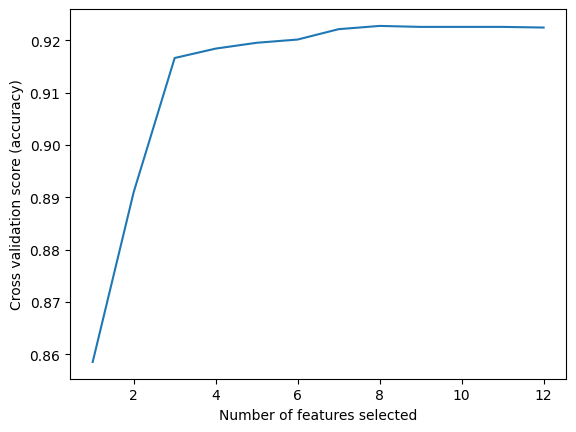

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import recall_score, accuracy_score, make_scorer, balanced_accuracy_score

# Assuming you have your train_features, train_labels, validation_features, and validation_labels


def plot_recurrentFE(min_features_to_select, rfecv):
  plt.figure()
  plt.xlabel("Number of features selected")
  plt.ylabel("Cross validation score (accuracy)")
  n_features = len(rfecv.cv_results_['mean_test_score'])
  plt.plot(range(min_features_to_select, min_features_to_select + n_features), rfecv.cv_results_['mean_test_score'])
  plt.show()

# 1. Recurrent feature elimination with cross-validation
# svc = SVC(kernel="linear")
svc = SVC(kernel="linear")

# clf = svm.SVC(C=1.0,
#               kernel='rbf', # linear ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
#               degree=6,
#               gamma='scale',
#               # coef0=0.0,
#               shrinking=True,
#               probability=False,
#               tol=0.001,
#               cache_size=200,
#               class_weight=None,
#               verbose=False,
#               max_iter=- 1,
#               decision_function_shape='ovr',
#               break_ties=False)

min_features_to_select = 1

# Use make_scorer to create a scorer for balanced accuracy
# balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)

rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(3),
              scoring='recall_weighted',
              min_features_to_select=min_features_to_select)

rfecv.fit(train_features_zscore, to_binary(train_labels))


# Adapt train, validation, and test set
train_features_selection = train_features_zscore.iloc[:, rfecv.support_]
validation_features_selection = validation_features_zscore[train_features_selection.columns]
test_features_selection = test_features_zscore[train_features_selection.columns]

fs_results_2 = pd.DataFrame({'ranking': rfecv.ranking_, 'selected': rfecv.support_},
                              index=[rfecv.feature_names_in_])
display(fs_results_2)

fs_results_1 = pd.DataFrame(rfecv.cv_results_)
display(fs_results_1)

# Plot number of features VS. cross-validation scores
plot_recurrentFE(min_features_to_select, rfecv)

# # 2. Print information to debug
# print("Unique labels in train_labels:", np.unique(to_binary(train_labels)))

# # 3. Adapt train & validation set based on selected features
# train_features_selected = train_features_zscore.iloc[:, rfecv.support_]
# validation_features_selected = validation_features_zscore[train_features_selected.columns]

# # 4. Print information to debug
# print("Unique labels in validation_labels:", np.unique(to_binary(validation_labels)))

# # 5. Evaluate model on validation set
# validation_predictions = rfecv.estimator_.predict(validation_features_selected)
# print(validation_predictions)

# validation_recall = recall_score(np.array(to_binary(validation_labels=='A')), validation_predictions=='A')
# validation_accuracy = accuracy_score(np.array(to_binary(validation_labels)=='A'), validation_predictions=='A')

# print("Optimal number of features: %d" % rfecv.n_features_)
# print("Validation Recall: %.4f" % validation_recall)
# print("Validation Accuracy: %.4f" % validation_accuracy)

In [29]:
train_features_selection.columns

Index(['crop_duration', 't_peak', 'kurt', 'auc', 'pulse_width',
       'spectral_entropy', 'PTP', 'A_to_N_ratio'],
      dtype='object')

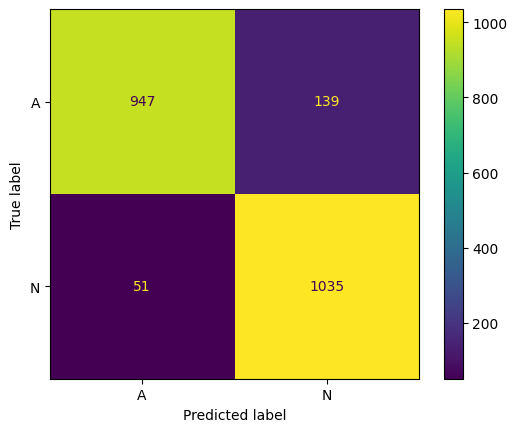

              precision    recall  f1-score   support

           A       0.95      0.87      0.91      1086
           N       0.88      0.95      0.92      1086

    accuracy                           0.91      2172
   macro avg       0.92      0.91      0.91      2172
weighted avg       0.92      0.91      0.91      2172



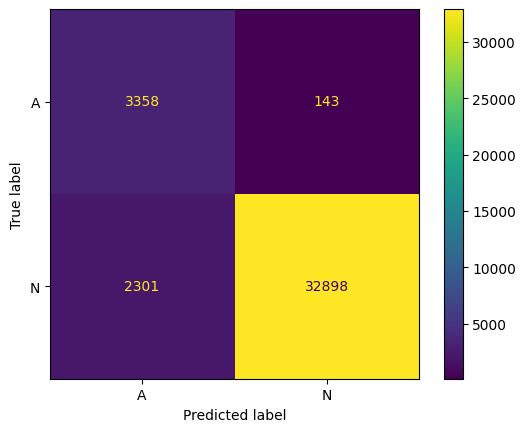

              precision    recall  f1-score   support

           A       0.59      0.96      0.73      3501
           N       1.00      0.93      0.96     35199

    accuracy                           0.94     38700
   macro avg       0.79      0.95      0.85     38700
weighted avg       0.96      0.94      0.94     38700



In [30]:
clf, val_prediction = testModel_2(train_features_selection, train_labels, validation_features_selection, validation_labels, clf)
clf, test_prediction = testModel_2(train_features_selection, train_labels, test_features_selection, test_labels, clf)

In [20]:
# from sklearn.svm import SVC
# from sklearn.feature_selection import RFE
# from sklearn.metrics import balanced_accuracy_score, recall_score

# # Create the RFE object
# svc = SVC(kernel="linear")
# min_features_to_select = 1

# # Initialize feature indices and performance history
# selected_features = list(range(train_features_zscore.shape[1]))
# validation_scores = []

# while len(selected_features) > min_features_to_select:
#     # Fit the model on the current set of features
#     svc.fit(train_features_zscore.iloc[:, selected_features], train_labels)

#     # Make predictions on the validation set
#     validation_predictions = svc.predict(validation_features_zscore.iloc[:, selected_features])

#     # Calculate the performance metric (e.g., balanced accuracy) on the validation set
#     validation_score = balanced_accuracy_score(validation_labels, validation_predictions)
#     validation_scores.append(validation_score)

#     # Get the least important feature and remove it from the selected features
#     least_important_feature = selected_features.pop(validation_score.argmin())

# print("Optimal number of features : %d" % len(selected_features))

# # Print or plot the results as needed

In [21]:
# validation_scores
# plot_recurrentFE(min_features_to_select, validation_scores)

In [ ]:
# from sklearn.svm import SVC
# from sklearn.feature_selection import RFE
# from sklearn.metrics import balanced_accuracy_score, recall_score
# import matplotlib.pyplot as plt

# # Assuming you have your train_features_zscore, train_labels, validation_features_zscore, and validation_labels

# # Create the RFE object
# svc = SVC(kernel="linear")
# min_features_to_select = 1

# # Initialize feature indices and performance history
# selected_features = list(range(train_features_zscore.shape[1]))
# validation_scores = []

# while len(selected_features) > min_features_to_select:
#     # Fit the model on the current set of features
#     svc.fit(train_features_zscore.iloc[:, selected_features], train_labels)

#     # Make predictions on the validation set
#     validation_predictions = svc.predict(validation_features_zscore.iloc[:, selected_features])

#     # Calculate the performance metric (e.g., balanced accuracy) on the validation set
#     validation_score = balanced_accuracy_score(validation_labels, validation_predictions)
#     validation_scores.append(validation_score)

#     # Get the least important feature and remove it from the selected features
#     if len(selected_features) > min_features_to_select:
#         min_index = validation_scores.index(min(validation_scores))
#         print(f"Current selected features: {selected_features}")
#         print(f"Current min_index: {min_index}")
        
#         least_important_feature = selected_features.pop(min_index)
#         print(f"Removed feature at index {least_important_feature}, current length of selected features: {len(selected_features)}")

# print("Optimal number of features: %d" % len(selected_features))

# # Print or plot the results as needed

# # Plotting the results
# plt.figure(figsize=(10, 6))
# plt.xlabel("Number of features selected")
# plt.ylabel("Validation Score")
# plt.plot(range(min_features_to_select, min_features_to_select + len(validation_scores)), validation_scores, marker='o')
# plt.title("Recursive Feature Elimination with Cross-Validation")
# plt.show()


In [ ]:
# # Plotting the results
# plt.figure(figsize=(10, 6))
# plt.xlabel("Number of features selected")
# plt.ylabel("Validation Score")
# plt.plot(range(min_features_to_select, min_features_to_select + len(validation_scores)), validation_scores, marker='o')
# plt.title("Recursive Feature Elimination with Cross-Validation")
# plt.show()

In [22]:
# # Create the RFE object and compute a cross-validated score.
# svc = SVC(kernel="linear")
# min_features_to_select = 1 ###################################################################

# rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(3), ###################################################
#               scoring='balanced_accuracy',
#               min_features_to_select=min_features_to_select)

# rfecv.fit(train_features, train_labels)

# print("Optimal number of features : %d" % rfecv.n_features_)

# # adapt train & validation set
# train_features = train_features.iloc[:, rfecv.support_]
# validation_features = validation_features[train_features.columns]

# fs_results_2 = pd.DataFrame({'ranking': rfecv.ranking_, 'selected': rfecv.support_},
#                               index = [rfecv.feature_names_in_])
# display(fs_results_2)

# fs_results_1 = pd.DataFrame(rfecv.cv_results_)
# display(fs_results_1)

# # Plot number of features VS. cross-validation scores
# plot_recurrentFE(min_features_to_select, rfecv)

In [23]:
# # 4. Plotting
# def plot_recurrentFE(min_features_to_select, rfecv):
#     plt.figure(figsize=(10, 6))
#     plt.xlabel("Number of features selected")
#     plt.ylabel("Validation Score")

#     # Assuming validation_scores is a list of tuples (recall, accuracy)
#     validation_scores = []
#     for feature_count, score in zip(
#         range(min_features_to_select, min_features_to_select + len(rfecv.grid_scores_)),
#         rfecv.grid_scores_
#     ):
#         validation_predictions = rfecv.estimator_.predict(validation_features_selected)
#         recall = recall_score(to_binary(validation_labels), validation_predictions, labels=['A', 'N'])
#         accuracy = accuracy_score(to_binary(validation_labels), validation_predictions, labels=['A', 'N'])
#         validation_scores.append((recall, accuracy))

#     recalls, accuracies = zip(*validation_scores)

#     # Combine recall and accuracy based on your specified weights
#     combined_scores = 0.8 * np.array(recalls) + 0.2 * np.array(accuracies)

#     plt.plot(
#         range(min_features_to_select, min_features_to_select + len(rfecv.grid_scores_)),
#         combined_scores,
#         marker='o'
#     )
#     plt.title("Recursive Feature Elimination with Cross-Validation")
#     plt.show()

# # 5. Plotting the results
# plot_recurrentFE(min_features_to_select, rfecv)

In [79]:
np.array(to_binary(validation_labels)), validation_predictions

(array(['N', 'N', 'A', ..., 'N', 'N', 'N'], dtype=object),
 array(['N', 'N', 'A', ..., 'N', 'N', 'N'], dtype=object))

In [83]:
np.array(to_binary(validation_labels) == 'A')

array([False, False,  True, ..., False, False, False])

In [77]:
np.sum(validation_predictions == 'A')

997

In [70]:
to_binary(train_labels)

0        A
1        N
2        A
3        N
4        A
        ..
16159    N
16160    N
16161    A
16162    N
16163    A
Name: labels, Length: 16164, dtype: object

In [43]:
clf.classes

AttributeError: 'SVC' object has no attribute 'classes'

In [41]:
rfecv

RFECV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
      estimator=SVC(kernel='linear'),
      scoring=make_scorer(balanced_accuracy_score))

In [405]:
# 3. Recurrent feature elimination with crossvalidation
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
min_features_to_select = 1 ###################################################################

rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(3), ###################################################
              scoring='balanced_accuracy',
              min_features_to_select=min_features_to_select)

rfecv.fit(train_features, train_labels)

print("Optimal number of features : %d" % rfecv.n_features_)

# adapt train & validation set
train_features = train_features.iloc[:, rfecv.support_]
validation_features = validation_features[train_features.columns]

fs_results_2 = pd.DataFrame({'ranking': rfecv.ranking_, 'selected': rfecv.support_},
                              index = [rfecv.feature_names_in_])
display(fs_results_2)

fs_results_1 = pd.DataFrame(rfecv.cv_results_)
display(fs_results_1)

# Plot number of features VS. cross-validation scores
plot_recurrentFE(min_features_to_select, rfecv)

ValueError: could not convert string to float: 'S'

In [207]:
# #---------------------------------------------------
# #               Feature scaling
# #---------------------------------------------------

# # Read in as copy
# train_features = train_df.copy()
# validation_features = val_df.copy()
# test_features = val_df.copy()

# # Select labels
# train_labels = train_features['labels']
# validation_labels = validation_features['labels']
# test_labels = test_features['labels']

# # Drop "useless" features
# train_features = train_features.drop(columns=['labels'])
# validation_features = validation_features.drop(columns=['labels'])
# test_features = test_features.drop(columns=['labels'])

# ### ----------- Outlier removal --------------------

# feature_list = train_features.columns
# print('Missing values before outlier removal: ' + str(train_features.isnull().sum().sum()))

# # apply zscore
# scaler = StandardScaler().fit(train_features)
# zscore_features = scaler.transform(train_features)

# # select all those values with zscore > -+ 3  as outliers
# abs_zscores = np.abs(zscore_features)

# outliers_detected = abs_zscores > 3
# print('Outliers detected (train): ' + str(np.sum(np.sum(outliers_detected))))

# # set outliers as missing values
# train_features[outliers_detected] = np.nan
# train_features =  pd.DataFrame(data=train_features, columns=feature_list)

# print('Missing values after outlier removal (train): ' + str(train_features.isnull().sum().sum()))

# abs_zscores =  pd.DataFrame(data=abs_zscores, columns=feature_list)
# plot_outliersAnalysis(abs_zscores, feature_list)
# display(train_features)

# # Apply to validation set
# zscore_features = scaler.transform(validation_features)
# abs_zscores = np.abs(zscore_features)
# outliers_detected = abs_zscores > 3
# print('Outliers detected (validation): ' + str(np.sum(np.sum(outliers_detected))))


# validation_features[outliers_detected] = np.nan
# validation_features =  pd.DataFrame(data=validation_features, columns=feature_list)

# print('Missing values after outlier removal (validation): ' + str(validation_features.isnull().sum().sum()))

In [208]:
# # Drop rows containing NaN values
# train_features = train_features.dropna()

# print(train_labels.value_counts())
      
# print(train_labels.loc[train_features.index].value_counts())

In [ ]:
### ---------- Missing data handling ---------------

# remove patients in training set with high percentage of missing data (TRAINING)
n_patiens_before = np.shape(train_features)[0]
train_features = train_features.dropna(thresh=np.shape(train_features)[1]/3)
n_patiens_after = np.shape(train_features)[0]
print('Number of patients dropped: ' + str(n_patiens_before-n_patiens_after))

# missing data imputation
# substitute by median
train_features_nan_median = train_features.fillna(train_features.median(axis=0))
validation_features_nan_median = validation_features.fillna(train_features.median(axis=0))

# Regression: KNN imputation
from sklearn.impute import KNNImputer
# define imputer
imputer = KNNImputer(n_neighbors=5 , weights='uniform', metric='nan_euclidean') #################################
# fit on the dataset
imputer.fit(train_features)

feature_list = train_features.columns

train_features_KNN = imputer.transform(train_features)
train_features_KNN =  pd.DataFrame(data=train_features_KNN, columns=feature_list)

validation_features_KNN = imputer.transform(validation_features)
validation_features_KNN =  pd.DataFrame(data=validation_features_KNN, columns=feature_list)

# testModel(train_features_KNN, train_labels, validation_features_KNN, validation_labels)

### ---------- Data standardization ----------------
# Standarize data with z-score transformation
from sklearn.preprocessing import StandardScaler

train_features_zscore = train_features_KNN
validation_features_zscore = validation_features_KNN

transformer = StandardScaler().fit(train_features_zscore)
train_features_zscore = transformer.transform(train_features_zscore)
train_features_zscore = pd.DataFrame(data=train_features_zscore, columns=feature_list)

# adapt validation set
validation_features_zscore = transformer.transform(validation_features_zscore)
validation_features_zscore = pd.DataFrame(data=validation_features_zscore, columns=feature_list)

display(train_features_zscore)

testModel(train_features_zscore, train_labels, validation_features_zscore, validation_labels)

ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (2).

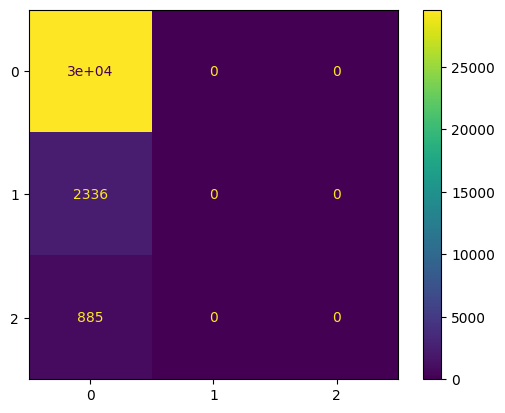

In [171]:
testModel(train_features_KNN, train_labels, validation_features_KNN, validation_labels)

### ---------- Data standardization ----------------
# Standarize data with z-score transformation
from sklearn.preprocessing import StandardScaler

train_features_zscore = train_features_KNN
validation_features_zscore = validation_features_KNN

transformer = StandardScaler().fit(train_features_zscore)
train_features_zscore = transformer.transform(train_features_zscore)
train_features_zscore = pd.DataFrame(data=train_features_zscore, columns=feature_list)

# adapt validation set
validation_features_zscore = transformer.transform(validation_features_zscore)
validation_features_zscore = pd.DataFrame(data=validation_features_zscore, columns=feature_list)

display(train_features_zscore)

testModel(train_features_zscore, train_labels, validation_features_zscore, validation_labels)

In [ ]:
# 3. Recurrent feature elimination with crossvalidation
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
min_features_to_select = 1 ###################################################################

rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(3), ###################################################
              scoring='balanced_accuracy',
              min_features_to_select=min_features_to_select)

rfecv.fit(train_features, train_labels)

print("Optimal number of features : %d" % rfecv.n_features_)

# adapt train & validation set
train_features = train_features.iloc[:, rfecv.support_]
validation_features = validation_features[train_features.columns]

fs_results_2 = pd.DataFrame({'ranking': rfecv.ranking_, 'selected': rfecv.support_},
                              index = [rfecv.feature_names_in_])
display(fs_results_2)

fs_results_1 = pd.DataFrame(rfecv.cv_results_)
display(fs_results_1)

# Plot number of features VS. cross-validation scores
plot_recurrentFE(min_features_to_select, rfecv)

In [139]:
# class FeatureConstructor:
#     def __init__(self, data_name=None):
#         """
#         :param
#             --data_name: filename like 'S001_128.mat' or tuple (data_path,label_path,peaks_path)
#         """
#         # Initialize class arguments
#         self.data_name = data_name

#         # Get information for patient with data_name
#         self.signal = OneSignal(data_name=self.data_name)
#         # Filter the PPG signal
#         self.signal.filter(fL = 0.5, fH = 4.3, order = 4)
#         # Align onsets to determine crops: always 1 peak between 2 onsets
#         self.signal.align_onsets()

#         # Set attributes of FeatureExtractor
#         self.ppg = self.signal.ppg              # get filtered ppg and derivatives
#         self.vpg = self.signal.vpg
#         self.apg = self.signal.apg
#         self.jpg = self.signal.jpg
#         self.fs = self.signal.fs                # sampling frequency                        --> int
#         self.peaks = self.signal.peaks.flatten()# peaks array                               --> (number_of_peaks,)
#         self.labels = self.signal.labels        # labels                                    --> (number_of_peaks,)
#         self.onsets = self.signal.on            # determined by self.signal.align_onsets()  --> (number_of_peaks+1,)


#     def generate_crops(self):
#         self.crops = []
#         while self.signal.indx < self.signal.indx_max:
#             # (x, y), (x_r, y_r) = self.signal.crop(raw=True)
#             crop, _ = self.signal.crop(raw=False)
#             self.crops.append(crop)

#     def get_intra_crop_features(self):
#         ""
#         self.ft_intra_crop_names = ['crop_duration','t_peak','mean','median','std','tvar','skew','kurt',
#                                     'auc','peak_amplitude','pulse_width','symmetry']
#         self.ft_intra_crop = np.zeros(((self.peaks.shape[0]), len(self.ft_intra_crop_names)))

#         # Construct self.crops
#         self.generate_crops()

#         # Loop over all crops: extract features
#         for i, crop in enumerate(self.crops):
#             self.ft_intra_crop[i,:] = np.array(
#                 [crop.shape[0] / self.fs,
#                  np.argmax(crop) / self.fs,
#                  np.mean(crop),
#                  np.median(crop),
#                  np.std(crop),
#                  tvar(crop), # tune values?
#                  skew(crop),
#                  kurtosis(crop),
#                  simps(np.abs(crop), dx=1/self.fs), # AUC: Simpson's rule for numeral integration
#                  np.max(crop)-np.min(crop),
#                  self.pulse_width(crop),
#                  self.symmetry_index(crop)
#                  ])

#     def get_inter_crop_features(self):
#         ""
#         self.ft_inter_crop_names = ['PTP','N_last_X_s']

#         self.ft_inter_crop = np.zeros(((self.peaks.shape[0]), len(self.ft_inter_crop_names)))
        
#         self.ft_inter_crop[:,0] = self.peak_to_peak_times()
#         self.ft_inter_crop[:,1] = self.N_ratio()

#     def get_patient_specific_features(self):
#         ""
#         self.ft_patient_names = ['name']
#         self.ft_patient = np.zeros(((self.peaks.shape[0]), len(self.ft_patient_names)))
        
#         self.ft_patient[:,0] = self.data_name.split('_')[0][1:]



#     def construct_dataframe(self, out_file=''):
#         # Get features
#         self.feature_names = self.ft_intra_crop_names + self.ft_inter_crop_names + self.ft_patient_names
#         features = np.concatenate([self.ft_intra_crop, self.ft_inter_crop, self.ft_patient], axis=-1)

#         # Create a DataFrame
#         data = {'peaks': self.peaks, 'labels': self.labels}
#         for i, feature_name in enumerate(self.feature_names):
#             data[feature_name] = features[:, i]

#         self.df = pd.DataFrame(data)

#         # Save DataFrame to .csv file
#         current_directory = os.path.dirname(os.path.abspath('__file__'))
#         folder_name = 'dataset/ML_features/'
#         target_folder = os.path.join(current_directory, folder_name)

#         ## Check if the folder exists and create it if not
#         if not os.path.exists(target_folder):
#             os.makedirs(target_folder)

#         file_path = os.path.join(target_folder, self.data_name.split('.')[0] + '.csv')
#         self.df.to_csv(file_path, index=False)

#     #---------------------------------------------------
#     #   Functions used in get_intra_crop_features()
#     #---------------------------------------------------
        
#     def pulse_width(self, crop):
#         if len(crop) == 0:
#             return 0  # or some default value, as appropriate
        
#         half_peak = max(crop) / 2
#         idx_peak = np.argmax(crop)
        
#         # Find indices on both sides of the peak
#         # Index of half value of peak before peak
#         idx_t1 = self.find_nearest(crop[:idx_peak], half_peak)
#         # Index of half value of peak after peak
#         idx_t2 = self.find_nearest(crop[idx_peak:], half_peak) + idx_peak

#         # Calculate the width
#         width = (idx_t2 - idx_t1)/self.fs # [s]

#         return width

#     #From https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
#     def find_nearest(self, array, value):
#         array = np.asarray(array)
#         if len(array) == 0:
#             idx = 0
#         else:
#             idx = (np.abs(array - value)).argmin()
#         return idx
    
#     def symmetry_index(self, crop):
#         middle_idx = len(crop) // 2
        
#         left_half = crop[:middle_idx]
#         right_half = crop[middle_idx:]
        
#         mean_left = np.mean(left_half)
#         mean_right = np.mean(right_half)

#         symmetry_index = mean_right / mean_left
        
#         return symmetry_index
    
#     #---------------------------------------------------
#     #   Functions used in get_inter_crop_features()
#     #---------------------------------------------------

#     def peak_to_peak_times(self):
#         time_between_peaks = np.diff(self.peaks) / self.fs
#         mean_PTP = np.mean(time_between_peaks)
#         time_between_peaks = mean_PTP
#         time_between_peaks = np.insert(time_between_peaks, 0, mean_PTP)

#         return time_between_peaks
    
#     def N_ratio(self, time_window=20):
#         indices_before = int(time_window*self.fs)

#         number_of_Ns = np.zeros(len(self.peaks))
#         for i, peak_idx in enumerate(self.peaks):
#             indices_in_window = np.where((peak_idx - indices_before <= self.peaks) & (self.peaks < peak_idx))[0]
#             count = np.count_nonzero(self.labels[indices_in_window] ==  'N')
#             number_of_Ns[i] = count

#         return number_of_Ns
        
#     # def drop_empty_crops(self, crops):

#     #     out = [crop for crop in crops if len(crop) > 4]
#     #     print("Number of crops eliminated: ", len(crops)-len(out))
#     #     return out

#     # def get_max_freq(self, crop, fs): #NEED FS OF INDIVIDUAL SIGNAL :(
#     #     fft = np.fft.fft(crop)
#     #     freqs = np.fft.fftfreq(len(crop), d=1/fs)
#     #     dom_freq_idx = np.argmax(np.abs(fft))
#     #     dom_freq = np.abs(freqs[dom_freq_idx])
#     #     return dom_freq

# current_directory = os.path.dirname(os.path.abspath('__file__'))
# folder_name = 'dataset/data/'
# target_folder = os.path.join(current_directory, folder_name)

# for file_name in tqdm(os.listdir(target_folder)[:2]):
#     print(file_name)
#     recording = FeatureConstructor('S001_128.mat')
#     recording.get_intra_crop_features()
#     recording.get_inter_crop_features()
#     recording.get_patient_specific_features()
#     recording.construct_dataframe()

# # 107/120

In [141]:
df['peak_amplitude']

0         3.111276
1         2.626051
2         2.832734
3         2.631315
4         1.944462
            ...   
244128    4.014716
244129    3.708280
244130    3.530775
244131    3.223087
244132    2.646441
Name: peak_amplitude, Length: 244133, dtype: float64

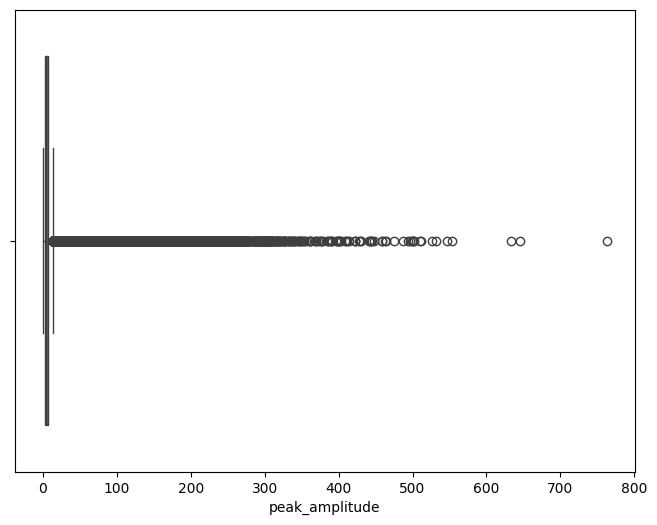

In [142]:
# Create a boxplot using seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(x='peak_amplitude', data=df)

# Show the plot
plt.show()

# Load in features & normalize

In [143]:
df

,peaks,labels,crop_duration,t_peak,mean,median,std,tvar,skew,kurt,...,peak_amplitude,pulse_width,symmetry,spectral_entropy,average_energy,rmssd,std_spectrogram,PTP,A_to_N_ratio,name
0,83,N,1.031250,0.632812,-0.074814,-0.345831,0.880778,0.781693,0.695468,-0.694012,...,3.111276,0.210938,-0.715613,1.103237,0.012297,0.062113,0.068949,0.690797,0.0,1.0
1,165,N,0.640625,0.250000,-0.074206,-0.091540,0.849451,0.730475,0.012791,-1.337709,...,2.626051,0.179688,-2.350049,0.993750,0.009069,0.070542,0.046523,0.640625,0.0,1.0
2,247,N,0.640625,0.250000,0.007296,-0.030241,0.917613,0.852409,0.042105,-1.364003,...,2.832734,0.187500,-0.954381,0.974546,0.010833,0.074184,0.058178,0.640625,0.0,1.0
3,330,N,0.562500,0.265625,0.064259,0.110945,0.824823,0.689915,-0.265204,-1.122555,...,2.631315,0.187500,-2.598195,0.968880,0.008414,0.071950,0.039970,0.648438,0.0,1.0
4,394,S,0.679688,0.234375,-0.119052,-0.184392,0.574101,0.333425,0.047393,-1.105410,...,1.944462,0.171875,-2.065566,0.966895,0.004433,0.043567,0.025463,0.500000,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244128,449149,N,0.728000,0.256000,0.305786,0.607647,1.094490,1.204527,-0.734365,-0.270232,...,4.014716,0.188000,1.178893,1.194078,0.006386,0.049120,0.035931,0.696000,0.0,121.0
244129,449324,N,0.720000,0.208000,-0.105226,-0.452086,1.028114,1.062923,0.216009,-0.807216,...,3.708280,0.168000,-1.330612,1.008371,0.007419,0.042227,0.057636,0.700000,0.0,121.0
244130,449511,N,0.768000,0.244000,-0.042105,0.040649,0.939306,0.886916,-0.259986,-0.546747,...,3.530775,0.164000,-1.526166,1.257259,0.004936,0.044077,0.028181,0.748000,0.0,121.0
244131,449703,N,0.600000,0.240000,0.347119,-0.043418,0.939167,0.887954,0.252589,-0.978847,...,3.223087,0.176000,0.235690,1.044008,0.006288,0.047865,0.038924,0.768000,0.0,121.0


In [4]:
from sklearn.model_selection import train_test_split

# Generate a list of numbers from 1 to 121 (excluding 107 and 120)
patient_numbers = [i for i in range(1, 122) if i not in [107, 120]+list(range(63, 79))]
print(len(patient_numbers))

# Set random state: reproducibility
random_state(36)

# Split the data into training (70%), validation (15%), and test (15%) sets
train_numbers, non_train_numbers = train_test_split(patient_numbers, test_size=0.3, random_state=36)
val_numbers, test_numbers = train_test_split(non_train_numbers, test_size=0.5, random_state=36)

# Print the lengths of the sets
print(f"Training set size: {len(train_numbers)}")
print(f"Validation set size: {len(val_numbers)}")
print(f"Test set size: {len(test_numbers)}")

# 2. Perform train-test stratified split
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random

# Select rows where the 'ID' column is in the predetermined list
train_df = df[df['name'].isin(train_numbers)]
val_df = df[df['name'].isin(val_numbers)]
test_df = df[df['name'].isin(test_numbers)]

# Drop "useless" features
train_df = train_df.drop(columns=['peaks', 'labels', 'name'])
val_df = val_df.drop(columns=['peaks', 'labels', 'name'])
test_df = test_df.drop(columns=['peaks', 'labels', 'name'])

103
Training set size: 72
Validation set size: 15
Test set size: 16


In [145]:
# features = df.drop(columns=['peaks', 'labels'])
# labels = df.labels




# train_full, test = train_test_split(features, test_size=0.2, shuffle=True,
#                                     stratify=labels)

# labels = train_full.label

# train, validation = train_test_split(train_full, test_size=0.25,
#                                      shuffle=True, stratify=labels)

# train_labels = train.label
# train_features = train.drop(columns='label')

# validation_labels = validation.label
# validation_features = validation.drop(columns='label')

# test_labels = test.label
# test_features = test.drop(columns='label')


# 1. Perform z-scoring for outlier removal
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, RobustScaler
import numpy as np

# feature_list = train_features.columns
# print('Missing values before outlier removal: ' + str(train_features.isnull().sum().sum()))

# # apply zscore
# scaler = StandardScaler().fit(features)
# zscore_features = scaler.transform(features)

# # select all those values with zscore > -+ 3  as outliers
# abs_zscores = np.abs(zscore_features)

# outliers_detected = abs_zscores > 3
# print('Outliers detected (train): ' + str(np.sum(np.sum(outliers_detected))))

# # set outliers as missing values
# train_features[outliers_detected] = np.nan
# train_features =  pd.DataFrame(data=train_features, columns=feature_list)

# print('Missing values after outlier removal (train): ' + str(train_features.isnull().sum().sum()))


# abs_zscores =  pd.DataFrame(data=abs_zscores, columns=feature_list)
# plot_outliersAnalysis(abs_zscores)
# display(train_features)

In [146]:
train_df

,crop_duration,t_peak,mean,median,std,tvar,skew,kurt,auc,peak_amplitude,pulse_width,symmetry,spectral_entropy,average_energy,rmssd,std_spectrogram,PTP,A_to_N_ratio
2603,1.187500,0.531250,-0.137542,-0.174041,0.610203,0.374813,0.327304,0.122749,0.573471,2.644502,0.179688,-4.521716,1.419786,0.004996,0.040979,0.026642,0.765439,0.000000
2604,0.835938,0.257812,0.191867,-0.028647,1.073234,1.162698,0.404985,-0.767363,0.676881,3.688874,0.195312,-0.441466,1.159771,0.014821,0.090450,0.071151,0.937500,1.000000
2605,0.828125,0.648438,-0.134108,-0.108065,1.106474,1.235944,-0.168062,-1.320787,0.800139,3.399380,0.140625,0.090509,1.002858,0.020052,0.124543,0.112323,0.812500,1.000000
2606,0.710938,0.195312,0.026860,0.115230,1.909596,3.687074,-0.486495,-0.337794,0.996920,7.030406,0.171875,-0.938495,1.080086,0.045897,0.145430,0.233011,0.796875,0.500000
2607,0.664062,0.375000,0.274432,0.500693,2.383523,5.748813,-0.367361,-1.096476,1.356800,7.457452,0.234375,-1.494914,0.924359,0.074953,0.156147,0.422145,0.804688,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244128,0.728000,0.256000,0.305786,0.607647,1.094490,1.204527,-0.734365,-0.270232,0.708380,4.014716,0.188000,1.178893,1.194078,0.006386,0.049120,0.035931,0.696000,0.000000
244129,0.720000,0.208000,-0.105226,-0.452086,1.028114,1.062923,0.216009,-0.807216,0.625204,3.708280,0.168000,-1.330612,1.008371,0.007419,0.042227,0.057636,0.700000,0.000000
244130,0.768000,0.244000,-0.042105,0.040649,0.939306,0.886916,-0.259986,-0.546747,0.544550,3.530775,0.164000,-1.526166,1.257259,0.004936,0.044077,0.028181,0.748000,0.000000
244131,0.600000,0.240000,0.347119,-0.043418,0.939167,0.887954,0.252589,-0.978847,0.455624,3.223087,0.176000,0.235690,1.044008,0.006288,0.047865,0.038924,0.768000,0.000000


In [147]:
val_df.peak_amplitude.max(), test_df.peak_amplitude.max()

(632.9872864322915, 645.1175084372959)

In [148]:
train_df.crop_duration.max(), val_df.crop_duration.max(), test_df.crop_duration.max()

(54.82, 3.0703125, 2.671875)

Missing values before outlier removal: 0
Outliers detected (train): 285284


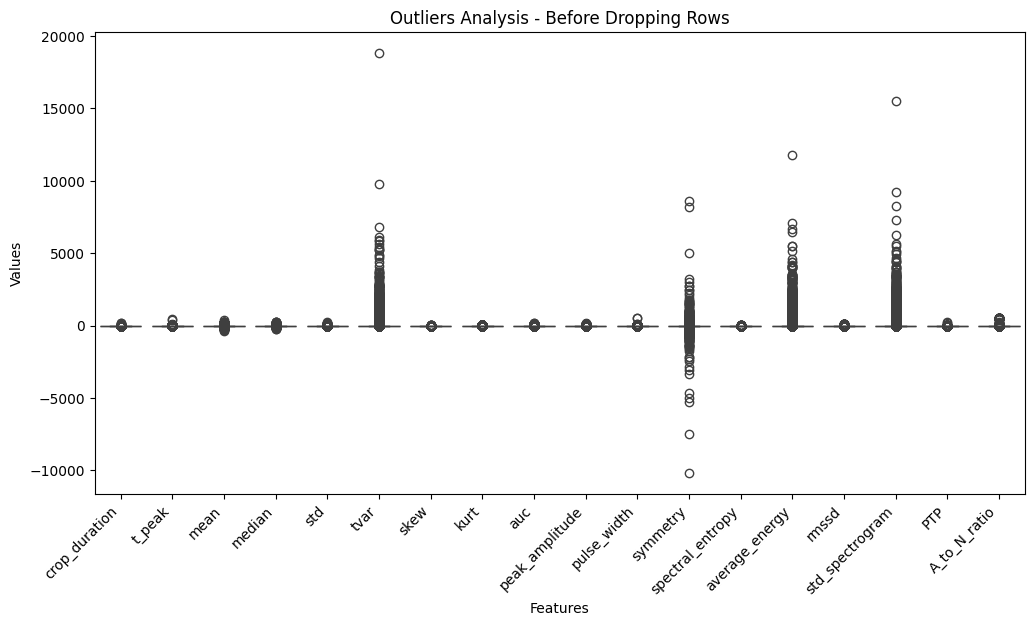

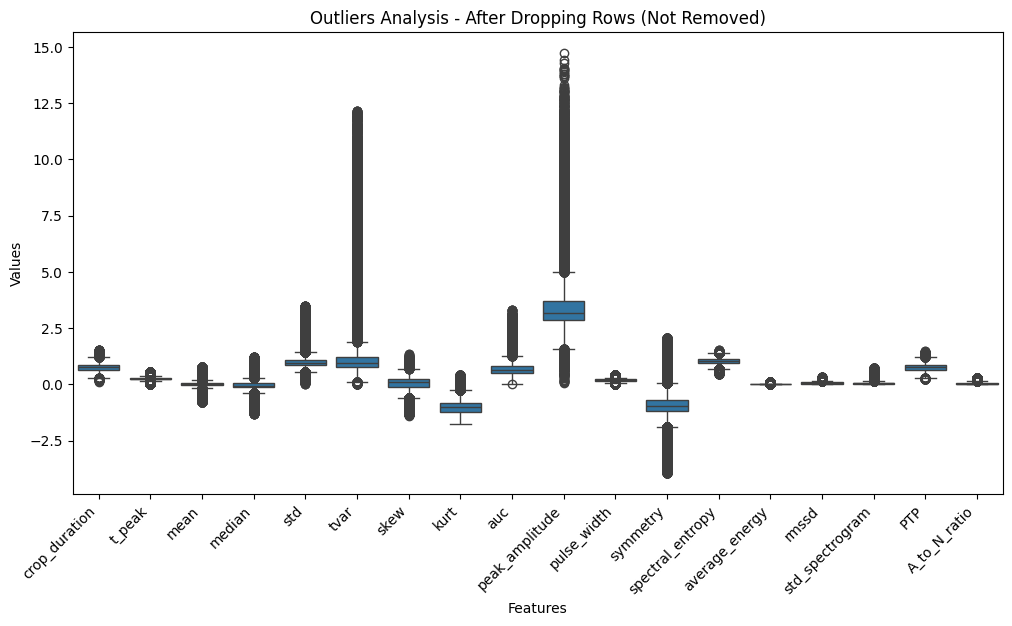

In [6]:
def plot_outliers_analysis(data, feature_list, title):
    # Function to plot outliers analysis
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="variable", y="value", data=pd.melt(data))
    plt.title(f'Outliers Analysis - {title}')
    plt.xlabel('Features')
    plt.ylabel('Values')
    plt.xticks(rotation=45, ha='right')
    plt.show()


train_features = train_df.copy()

feature_list = train_features.columns
print('Missing values before outlier removal: ' + str(train_features.isnull().sum().sum()))

# apply RobustScaler
scaler = RobustScaler().fit(train_features)
robust_scaled_features = scaler.transform(train_features)

# select all those values with absolute value > 3 as outliers
outliers_detected = np.abs(robust_scaled_features) > 3
print('Outliers detected (train): ' + str(np.sum(np.sum(outliers_detected))))

# set outliers as missing values
train_features[outliers_detected] = np.nan
# Drop rows containing NaN values
train_features = train_features.dropna()

# Plot outliers analysis before dropping rows
robust_scaled_features_before_drop = pd.DataFrame(data=robust_scaled_features, columns=feature_list)
plot_outliers_analysis(robust_scaled_features_before_drop, feature_list, "Before Dropping Rows")
# Plot outliers analysis after dropping rows without actually dropping them
plot_outliers_analysis(train_features, feature_list, "After Dropping Rows (Not Removed)")
# # Display the resulting DataFrame
# display(train_features)

In [130]:
train_df

,crop_duration,t_peak,mean,median,std,tvar,skew,kurt,auc,peak_amplitude,pulse_width,symmetry,spectral_entropy,average_energy,rmssd,std_spectrogram,PTP,A_to_N_ratio
2603,1.187500,0.531250,-0.137542,-0.174041,0.610203,0.374813,0.327304,0.122749,0.573471,2.644502,0.179688,-4.521716,1.419786,0.004996,0.040979,0.026642,0.765439,0.000000
2604,0.835938,0.257812,0.191867,-0.028647,1.073234,1.162698,0.404985,-0.767363,0.676881,3.688874,0.195312,-0.441466,1.159771,0.014821,0.090450,0.071151,0.937500,1.000000
2605,0.828125,0.648438,-0.134108,-0.108065,1.106474,1.235944,-0.168062,-1.320787,0.800139,3.399380,0.140625,0.090509,1.002858,0.020052,0.124543,0.112323,0.812500,1.000000
2606,0.710938,0.195312,0.026860,0.115230,1.909596,3.687074,-0.486495,-0.337794,0.996920,7.030406,0.171875,-0.938495,1.080086,0.045897,0.145430,0.233011,0.796875,0.500000
2607,0.664062,0.375000,0.274432,0.500693,2.383523,5.748813,-0.367361,-1.096476,1.356800,7.457452,0.234375,-1.494914,0.924359,0.074953,0.156147,0.422145,0.804688,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244128,0.728000,0.256000,0.305786,0.607647,1.094490,1.204527,-0.734365,-0.270232,0.708380,4.014716,0.188000,1.178893,1.194078,0.006386,0.049120,0.035931,0.696000,0.000000
244129,0.720000,0.208000,-0.105226,-0.452086,1.028114,1.062923,0.216009,-0.807216,0.625204,3.708280,0.168000,-1.330612,1.008371,0.007419,0.042227,0.057636,0.700000,0.000000
244130,0.768000,0.244000,-0.042105,0.040649,0.939306,0.886916,-0.259986,-0.546747,0.544550,3.530775,0.164000,-1.526166,1.257259,0.004936,0.044077,0.028181,0.748000,0.000000
244131,0.600000,0.240000,0.347119,-0.043418,0.939167,0.887954,0.252589,-0.978847,0.455624,3.223087,0.176000,0.235690,1.044008,0.006288,0.047865,0.038924,0.768000,0.000000


In [7]:
train_features

,crop_duration,t_peak,mean,median,std,tvar,skew,kurt,auc,peak_amplitude,pulse_width,symmetry,spectral_entropy,average_energy,rmssd,std_spectrogram,PTP,A_to_N_ratio
2625,0.812500,0.265625,0.308410,0.416018,1.102891,1.228178,-0.114108,-0.799158,0.765074,3.934727,0.203125,0.039489,1.221636,0.013758,0.091987,0.061225,0.804688,0.100000
2626,0.773438,0.226562,-0.191902,-0.414043,0.967312,0.945241,0.379454,-0.783668,0.643124,3.462835,0.164062,-1.917135,1.118877,0.012557,0.082071,0.064392,0.789062,0.095238
2627,0.460938,0.242188,0.235769,0.365543,1.068017,1.160327,-0.603882,-0.776838,0.418993,3.429139,0.171875,-2.416668,0.950783,0.014212,0.100652,0.062065,0.773438,0.090909
2628,0.937500,0.265625,-0.163999,-0.309548,0.607022,0.371572,-0.175311,-0.754529,0.485199,2.244917,0.210938,-1.969845,0.967755,0.004829,0.031093,0.031813,0.468750,0.086957
2629,0.843750,0.257812,0.167337,-0.036942,1.093373,1.206636,0.404249,-0.772870,0.698156,3.801830,0.195312,-0.530576,1.169960,0.015316,0.090628,0.075037,0.960938,0.086957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244128,0.728000,0.256000,0.305786,0.607647,1.094490,1.204527,-0.734365,-0.270232,0.708380,4.014716,0.188000,1.178893,1.194078,0.006386,0.049120,0.035931,0.696000,0.000000
244129,0.720000,0.208000,-0.105226,-0.452086,1.028114,1.062923,0.216009,-0.807216,0.625204,3.708280,0.168000,-1.330612,1.008371,0.007419,0.042227,0.057636,0.700000,0.000000
244130,0.768000,0.244000,-0.042105,0.040649,0.939306,0.886916,-0.259986,-0.546747,0.544550,3.530775,0.164000,-1.526166,1.257259,0.004936,0.044077,0.028181,0.748000,0.000000
244131,0.600000,0.240000,0.347119,-0.043418,0.939167,0.887954,0.252589,-0.978847,0.455624,3.223087,0.176000,0.235690,1.044008,0.006288,0.047865,0.038924,0.768000,0.000000


In [ ]:
# 2. Standarize data with z-score transformation
from sklearn.preprocessing import StandardScaler

train_features_zscore = train_features_KNN
validation_features_zscore = validation_features_KNN

transformer = StandardScaler().fit(train_features_zscore)
train_features_zscore = transformer.transform(train_features_zscore)
train_features_zscore = pd.DataFrame(data=train_features_zscore, columns=feature_list)

# adapt validation set
validation_features_zscore = transformer.transform(validation_features_zscore)
validation_features_zscore = pd.DataFrame(data=validation_features_zscore, columns=feature_list)

display(train_features_zscore)

In [83]:
"Given functions"
def plot_outliersAnalysis(abs_zscores, feature_list):
  # number of outliers per subject
  bool_zscores = (abs_zscores > 5).sum(axis=1)
  bool_zscores.hist()
  plt.title("Number of outliers per subject")
  plt.show()

  # number of outliers per feature
  bool_zscores = (abs_zscores > 5).sum(axis=0)
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])

  ax.bar(feature_list,bool_zscores)
  plt.title("Number of outliers per feature")
  plt.xticks(np.arange(len(feature_list)), feature_list,rotation=90)
  plt.show()
  return

In [150]:
# # 1. Perform z-scoring for outlier removal
# from scipy.stats import zscore
# from sklearn.preprocessing import StandardScaler
# import numpy as np

# train_features = train_df
# validation_features = val_df

# feature_list = train_features.columns
# print('Missing values before outlier removal: ' + str(train_features.isnull().sum().sum()))

# # apply zscore
# scaler = StandardScaler().fit(train_features)
# zscore_features = scaler.transform(train_features)

# # select all those values with zscore > -+ 3  as outliers
# abs_zscores = np.abs(zscore_features)

# outliers_detected = abs_zscores > 2
# print('Outliers detected (train): ' + str(np.sum(np.sum(outliers_detected))))

# # set outliers as missing values
# train_features[outliers_detected] = np.nan
# train_features =  pd.DataFrame(data=train_features, columns=feature_list)

# print('Missing values after outlier removal (train): ' + str(train_features.isnull().sum().sum()))


# abs_zscores =  pd.DataFrame(data=abs_zscores, columns=feature_list)
# plot_outliersAnalysis(abs_zscores, feature_list)
# display(train_features)

# # Apply to validation set
# zscore_features = scaler.transform(validation_features)
# abs_zscores = np.abs(zscore_features)
# outliers_detected = abs_zscores > 3
# print('Outliers detected (validation): ' + str(np.sum(np.sum(outliers_detected))))


# validation_features[outliers_detected] = np.nan
# validation_features =  pd.DataFrame(data=validation_features, columns=feature_list)

# print('Missing values after outlier removal (validation): ' + str(validation_features.isnull().sum().sum()))

In [99]:
train_df

,crop_duration,t_peak,mean,median,std,tvar,skew,kurt,auc,peak_amplitude,pulse_width,symmetry,spectral_entropy,average_energy,rmssd,std_spectrogram,PTP,A_to_N_ratio
2603,1.187500,0.531250,-0.137542,-0.174041,0.610203,0.374813,0.327304,0.122749,0.573471,2.644502,0.179688,-4.521716,1.419786,0.004996,0.040979,0.026642,0.765439,0.000000
2604,0.835938,0.257812,0.191867,-0.028647,1.073234,1.162698,0.404985,-0.767363,0.676881,3.688874,0.195312,-0.441466,1.159771,0.014821,0.090450,0.071151,0.937500,NaN
2605,0.828125,0.648438,-0.134108,-0.108065,1.106474,1.235944,-0.168062,-1.320787,0.800139,3.399380,0.140625,0.090509,1.002858,0.020052,0.124543,0.112323,0.812500,NaN
2606,0.710938,0.195312,0.026860,0.115230,1.909596,3.687074,-0.486495,-0.337794,0.996920,7.030406,0.171875,-0.938495,1.080086,0.045897,0.145430,0.233011,0.796875,0.500000
2607,0.664062,0.375000,0.274432,0.500693,2.383523,5.748813,-0.367361,-1.096476,1.356800,7.457452,0.234375,-1.494914,0.924359,0.074953,0.156147,0.422145,0.804688,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244128,0.728000,0.256000,0.305786,0.607647,1.094490,1.204527,-0.734365,-0.270232,0.708380,4.014716,0.188000,1.178893,1.194078,0.006386,0.049120,0.035931,0.696000,0.000000
244129,0.720000,0.208000,-0.105226,-0.452086,1.028114,1.062923,0.216009,-0.807216,0.625204,3.708280,0.168000,-1.330612,1.008371,0.007419,0.042227,0.057636,0.700000,0.000000
244130,0.768000,0.244000,-0.042105,0.040649,0.939306,0.886916,-0.259986,-0.546747,0.544550,3.530775,0.164000,-1.526166,1.257259,0.004936,0.044077,0.028181,0.748000,0.000000
244131,0.600000,0.240000,0.347119,-0.043418,0.939167,0.887954,0.252589,-0.978847,0.455624,3.223087,0.176000,0.235690,1.044008,0.006288,0.047865,0.038924,0.768000,0.000000
